<p style="font-size:3em">Conceive an application for public health </p>

<br/>

This notebook corresponds to the second part of the **3rd project of my data scientist path** with **OpenClassrooms/CentralSupelec** 

This project corresponds to a reinforcement of the EDA, univariate and multivariate analysis skills

This notebook contains the following steps:<br/>

* Overview of the remaining features distribution  
* Perform several statistical tests (correlation-Pearson, Kolmogorov-Smirnov, ANOVA)
* Overview of PCA reduction + first two components representation
* Predict nutriscore with Linear regression and KNNRegressor
* Study of the NaN influence on the results (as we imput the missing values) 

___
<b>I strongly recommend to use the 'table of content' extension of Jupyter to navigate through this notebook </b>

# Imports

In [2]:
#import packages
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import pickle
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV
from scipy import stats,spatial

In [3]:
train= pd.read_csv("train.csv")
test= pd.read_csv("test.csv")
test_2= pd.read_csv("test_2.csv")
train.drop(columns='mean',inplace=True)


# Analysis 

## Distribution Overview

In [3]:
train.shape

(362937, 10)

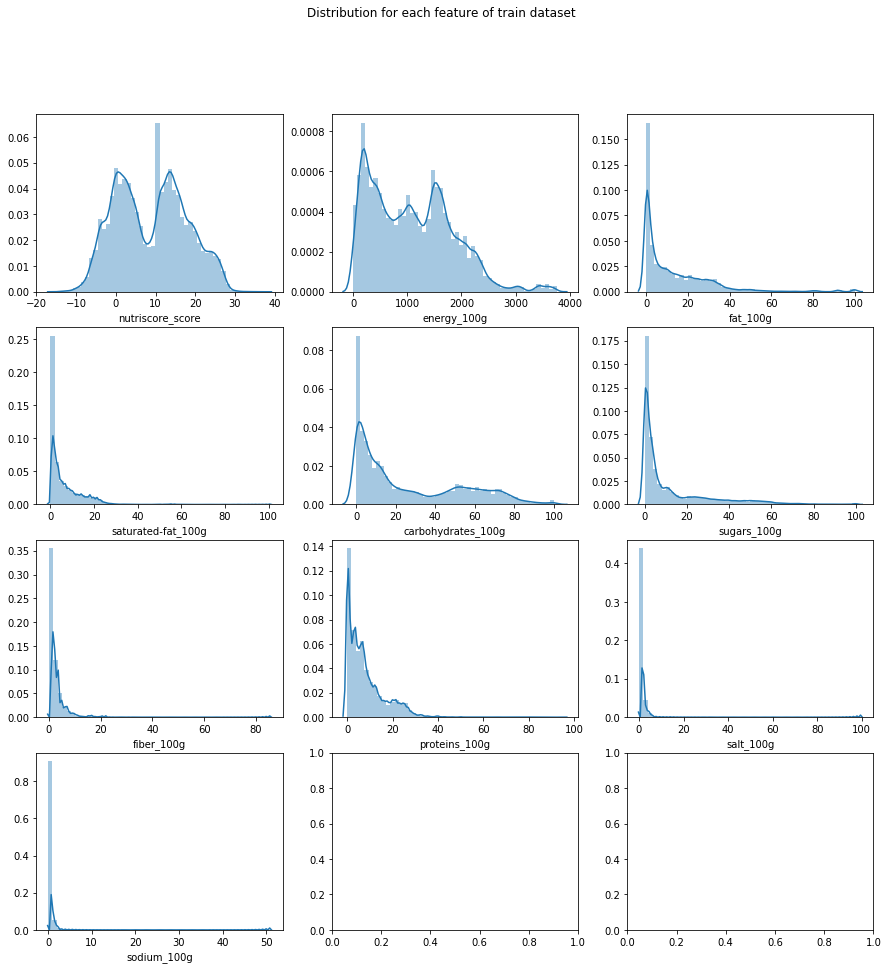

In [230]:
fig, axs = plt.subplots(4,3,figsize=(15,15))
axs = axs.ravel()

for i in range(train.shape[1]): 
    sns.distplot(train[train.columns[i]],ax=axs[i])
fig.suptitle('Distribution for each feature of train dataset') # or plt.suptitle('Main title')
plt.show()

In [228]:
train[train.columns[0]]

0         13.0
1         19.0
2         21.0
3          8.0
4         -4.0
          ... 
362932    11.0
362933    19.0
362934    23.0
362935     0.0
362936     1.0
Name: nutriscore_score, Length: 362937, dtype: float64

## Correlation (Pearson)

In [9]:
train.corr().reindex(['nutriscore_score'],axis=1)

,nutriscore_score
nutriscore_score,1.000000
energy_100g,0.604385
fat_100g,0.517130
saturated-fat_100g,0.592170
carbohydrates_100g,0.245153
sugars_100g,0.426215
fiber_100g,-0.114125
proteins_100g,0.108050
salt_100g,0.140641
sodium_100g,0.139524


In [36]:
test_pear = pd.DataFrame(columns=['coef_pearson','p_value'])
for i in range(1,len(train.columns)):

    pear, pval = stats.pearsonr(train['nutriscore_score'], train[train.columns[i]])
    test_pear.loc[train.columns[i]]=[pear,pval]
    
test_pear
                

,coef_pearson,p_value
energy_100g,0.604385,0.0
fat_100g,0.517130,0.0
saturated-fat_100g,0.592170,0.0
carbohydrates_100g,0.245153,0.0
sugars_100g,0.426215,0.0
fiber_100g,-0.114125,0.0
proteins_100g,0.108050,0.0
salt_100g,0.140641,0.0
sodium_100g,0.139524,0.0


Null Hypothesis : Correlation between the two studied features is null

Null Hypothesis rejected (pvalue = 0) 

=> The correlation between our features are not null 

Text(0.5, 0.98, 'Nutriscore_score correlation with other features')

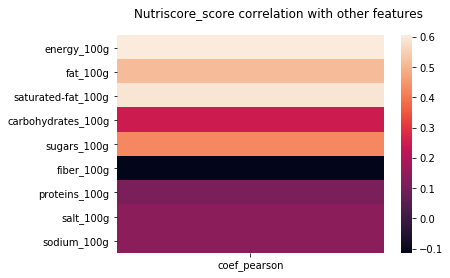

In [37]:
sns.heatmap(test_pear.drop(columns=['p_value']))
plt.suptitle('Nutriscore_score correlation with other features')

We can observe a significant correlation between following features : 

- energy
- fat & saturated-fat 
- sugars

In [31]:
# test_linreg = pd.DataFrame(columns=['coef_pearson','p_value'])
# for i in range(1,len(train.columns)):

#     slope, intercept, r_value, p_value, std_err = stats.linregress(train['nutriscore_score'], train[train.columns[i]])
#     test_linreg.loc[train.columns[i]]=[slope,p_value]
    
# test_linreg

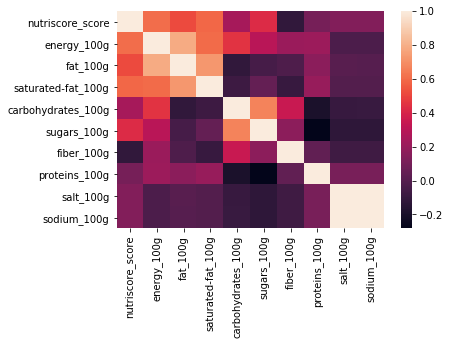

In [34]:
sns.heatmap(train.corr())

We can observe a significant correlation between following features : 

- fat/ saturated-fat
- carbohydrates/ sugars 
- salt/sodium 

We need to keep this in mind for the next steps of our project (potentially reduce the number of feature for the prediction ?)

On observe une assez forte corrélation pour les couples suivants:

- fat/ saturated-fat
- carbohydrates/ sugars 
- salt/sodium 

## Test de normalité (Kolmogorov-Smirnov)

In [43]:
alpha= 0.05
print('===================\nnull hypothesis : studied feature follow a normal distribution.\n ===================\n\n')

for i in range(len(train.columns)): 
    
    D, pval = stats.kstest(train[train.columns[i]], 'norm')
    print('D= {}\nP-value= {}'.format(D,pval))
    if pval<alpha: 
        print('P-value is lower than alpha ({}) we can reject the null hypothesis\n => {} does not follow normal distribution'
              .format(alpha,train.columns[i]))
    else : 
        print('We cannot reject the null hypothesis')
    print('----------------\n')
    

null hypothesis : studied feature follow a normal distribution.


D= 0.718031325990802
P-value= 0.0
P-value is lower than alpha (0.05) we can reject the null hypothesis
 => nutriscore_score does not follow normal distribution
----------------

D= 0.9882169779727689
P-value= 0.0
P-value is lower than alpha (0.05) we can reject the null hypothesis
 => energy_100g does not follow normal distribution
----------------

D= 0.6546795418476797
P-value= 0.0
P-value is lower than alpha (0.05) we can reject the null hypothesis
 => fat_100g does not follow normal distribution
----------------

D= 0.5
P-value= 0.0
P-value is lower than alpha (0.05) we can reject the null hypothesis
 => saturated-fat_100g does not follow normal distribution
----------------

D= 0.8025115525866023
P-value= 0.0
P-value is lower than alpha (0.05) we can reject the null hypothesis
 => carbohydrates_100g does not follow normal distribution
----------------

D= 0.6187504381386085
P-value= 0.0
P-value is lower than alpha (

## Test ANOVA 

In [59]:
nutriscore_range = train['nutriscore_score'].max()-train['nutriscore_score'].min()
print('Gap in each bin :',nutriscore_range/5)

Gap in each bin : 10.4


In [4]:
starting_value = -15
# Gap rounded up 
gap = 11
bins=[]
for i in range(6):
    bins.append(starting_value+i*gap)
labels=['a','b','c','d','e']


train['binned'] = pd.cut(train['nutriscore_score'], bins=bins, labels=labels)
train.head()

,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,binned
0,13.0,1071.0,1.776357e-15,0.00,61.54,58.97,0.00,0.00,0.00,0.000,c
1,19.0,1393.0,2.667000e+01,16.67,3.33,0.00,0.00,23.33,2.50,1.000,d
2,21.0,1690.0,1.260000e+01,6.60,67.10,46.90,1.88,3.30,0.13,0.052,d
3,8.0,431.0,7.800000e+00,3.90,4.20,1.20,0.78,4.10,1.40,0.560,c
4,-4.0,247.0,2.800000e+00,1.90,1.80,0.70,1.40,2.70,0.67,0.268,b


In [5]:
cols = train.columns[1:-1].tolist()
cols    

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

In [6]:
F, p = stats.f_oneway(train.loc[train["binned"] == 'a',cols],
                      train.loc[train["binned"] == 'b',cols],
                      train.loc[train["binned"] == 'c',cols],
                      train.loc[train["binned"] == 'd',cols],
                      train.loc[train["binned"] == 'e',cols])

# F, p = stats.f_oneway(train.loc[train["binned"] == 'a','energy_100g'],
#                       train.loc[train["binned"] == 'b','energy_100g'],
#                       train.loc[train["binned"] == 'c','energy_100g'],
#                       train.loc[train["binned"] == 'd','energy_100g'],
#                       train.loc[train["binned"] == 'e','energy_100g'])
F, p

(array([48402.01888759, 29275.87117464, 47963.33863191,  6747.89798602,
        18350.68448117,  3257.26735465,  1461.44423591,  2663.10104347,
         2623.95862778]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [88]:
results_anova =pd.DataFrame(columns=['F','P_value'])
for i in range(len(cols)):
    results_anova.loc[cols[i]]=[F[i],p[i]]
results_anova   

,F,P_value
energy_100g,48402.018888,0.0
fat_100g,29275.871175,0.0
saturated-fat_100g,47963.338632,0.0
carbohydrates_100g,6747.897986,0.0
sugars_100g,18350.684481,0.0
fiber_100g,3257.267355,0.0
proteins_100g,1461.444236,0.0
salt_100g,2663.101043,0.0
sodium_100g,2623.958628,0.0


Results to be put into perspective, as our data does not follow a normal distribution 

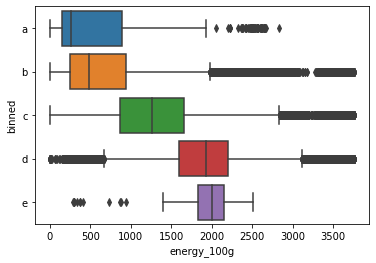

In [80]:
sns.boxplot(y='binned',x='energy_100g',data=train)


## PCA 

In [94]:
data_pca = train.copy()
data_pca.drop(columns=['nutriscore_score','binned'],inplace=True)
data_pca

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,1071.0,1.776357e-15,0.00,61.54,58.97,0.00,0.00,0.0000,0.000
1,1393.0,2.667000e+01,16.67,3.33,0.00,0.00,23.33,2.5000,1.000
2,1690.0,1.260000e+01,6.60,67.10,46.90,1.88,3.30,0.1300,0.052
3,431.0,7.800000e+00,3.90,4.20,1.20,0.78,4.10,1.4000,0.560
4,247.0,2.800000e+00,1.90,1.80,0.70,1.40,2.70,0.6700,0.268
...,...,...,...,...,...,...,...,...,...
362932,1891.0,1.667000e+01,2.38,69.05,26.19,4.80,7.14,1.0125,0.405
362933,1611.0,1.410000e+01,5.77,58.97,44.87,2.60,3.85,0.7700,0.308
362934,2205.0,3.700000e+01,16.00,38.00,35.00,2.17,10.00,0.0500,0.020
362935,4.0,1.000000e-01,0.10,0.10,0.10,0.00,0.10,0.0100,0.004


In [100]:
to_standard = data_pca.values
to_standard
scaler= StandardScaler()
standard = scaler.fit_transform(to_standard)
standard

array([[-0.02919741, -0.78383668, -0.66177255, ..., -0.93980756,
        -0.36395264, -0.36099288],
       [ 0.39727142,  0.78974923,  1.50538596, ...,  1.7914962 ,
         0.50222954,  0.49749468],
       [ 0.79062931, -0.04041027,  0.19625061, ..., -0.55346798,
        -0.31891117, -0.31635152],
       ...,
       [ 1.47271455,  1.39924089,  1.41828361, ...,  0.23091845,
        -0.34662899, -0.34382312],
       [-1.44237206, -0.77793647, -0.6487722 , ..., -0.9281003 ,
        -0.36048791, -0.35755893],
       [-0.67154953, -0.31181991, -0.44466669, ..., -0.62722371,
        -0.31458025, -0.31205908]])

In [101]:
pca = PCA()
data_pca = pca.fit_transform(standard)

Variance Ratio(%) :  [28.3 25.3 19.6 11.7  7.6  4.3  2.9  0.2  0. ]


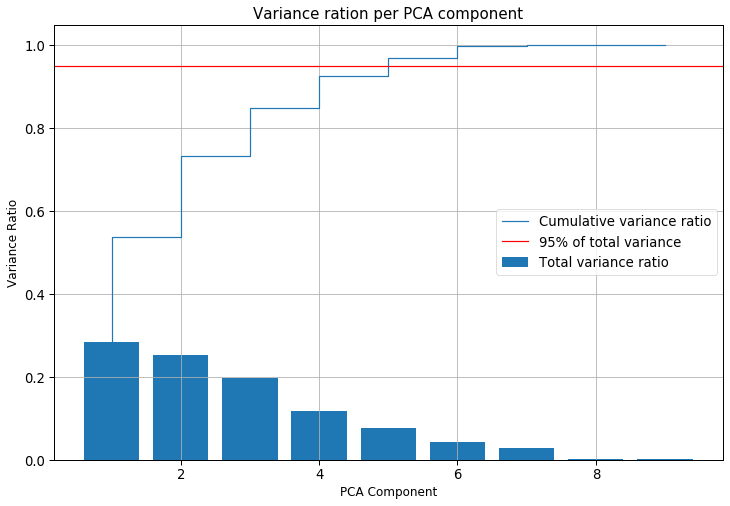

In [163]:
var_ratio = pca.explained_variance_ratio_
print('Variance Ratio(%) : ',np.around(var_ratio*100,1))
plt.figure(figsize=(12,8))
plt.bar(range(1,len(var_ratio)+1),var_ratio,align='center',label='Total variance ratio')
plt.step(range(1,len(var_ratio)+1),np.cumsum(var_ratio),label='Cumulative variance ratio')
plt.axhline(y=0.95,color='red',label='95% of total variance')
plt.xlabel('PCA Component',fontsize=12)
plt.ylabel('Variance Ratio',fontsize=12)
plt.legend(loc=7)
plt.title('Variance ration per PCA component',fontsize=15)
plt.grid()
plt.show()

Eigen Values :  [2.55147461 2.27376608 1.76178632 1.05428101 0.68702743 0.39022723
 0.25739041 0.02118502 0.00288668] 
-------------



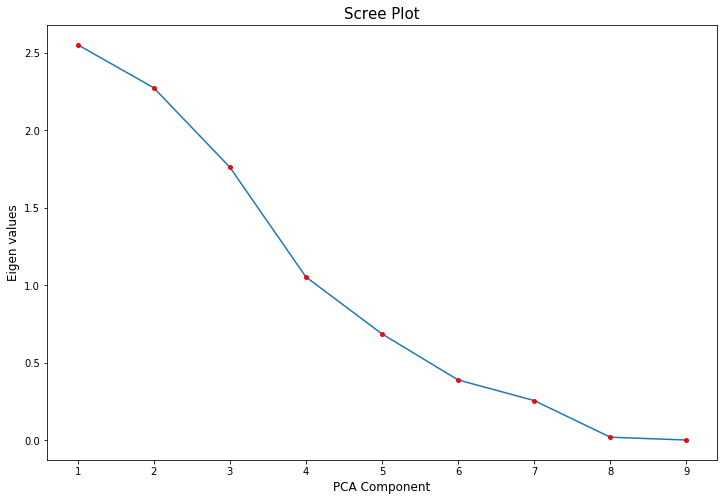

In [135]:
eigen_values = pca.explained_variance_
print('Eigen Values : ',eigen_values,'\n-------------\n')

plt.figure(figsize=(12,8))
plt.plot(range(1,len(eigen_values)+1),eigen_values,marker='.',mec='r',mew=2)
plt.title('Scree Plot',fontsize=15)
plt.ylabel("Eigen values",fontsize=12)
plt.xlabel("PCA Component",fontsize=12)
plt.show()


[ 0.59363116  0.50659154  0.46993956  0.24454215  0.23256657  0.13970231
  0.11301942 -0.10944306 -0.10939782] 
 [ 0.05185164  0.26773262  0.24455381 -0.38858769 -0.37646106 -0.21313776
  0.29718089  0.46895291  0.46844397]


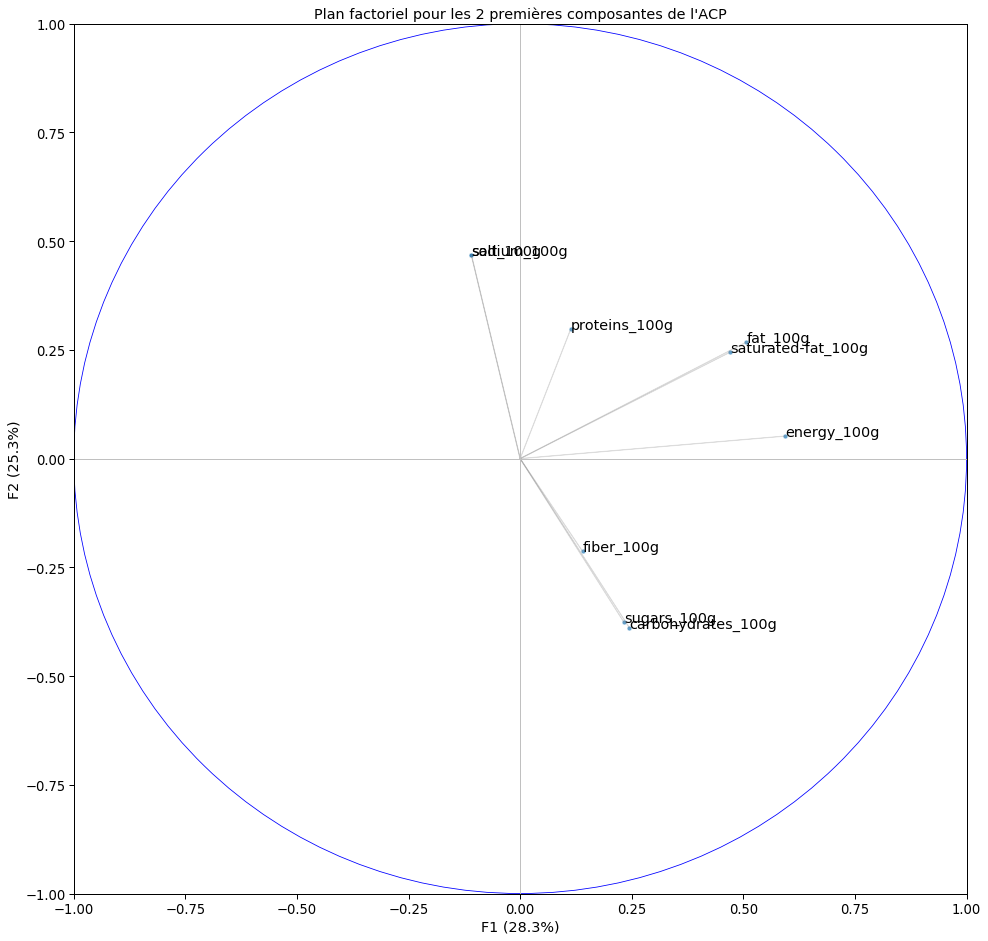

In [168]:
xpca =pca.components_[0,:]
ypca =pca.components_[1,:]

print(pca.components_[0,:],'\n',pca.components_[1,:])
fig, axes = plt.subplots(figsize=(16,16))

plt.title("Plan factoriel pour les 2 premières composantes de l'ACP")
plt.xlabel('F1 ({}%)'.format(np.around(var_ratio[0]*100,1)))
plt.ylabel('F2 ({}%)'.format(np.around(var_ratio[1]*100,1)))

axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

sns.scatterplot(x= xpca, y= ypca ,alpha = 0.7)

for i in range(len(cols)):
    plt.annotate(cols[i], (xpca[i],ypca[i]))
    axes.arrow(0, 0, xpca[i], ypca[i], head_width=0, head_length=0, fc='grey', ec='grey',alpha=0.2)

[ 0.10352493 -0.16456192 -0.16602834  0.44433018  0.36643378  0.24052013
 -0.13460979  0.51303098  0.51357863] 
 [ 0.05520533 -0.12428467 -0.20359643  0.03955629 -0.26655213  0.67349278
  0.63868576 -0.05414973 -0.05472872]


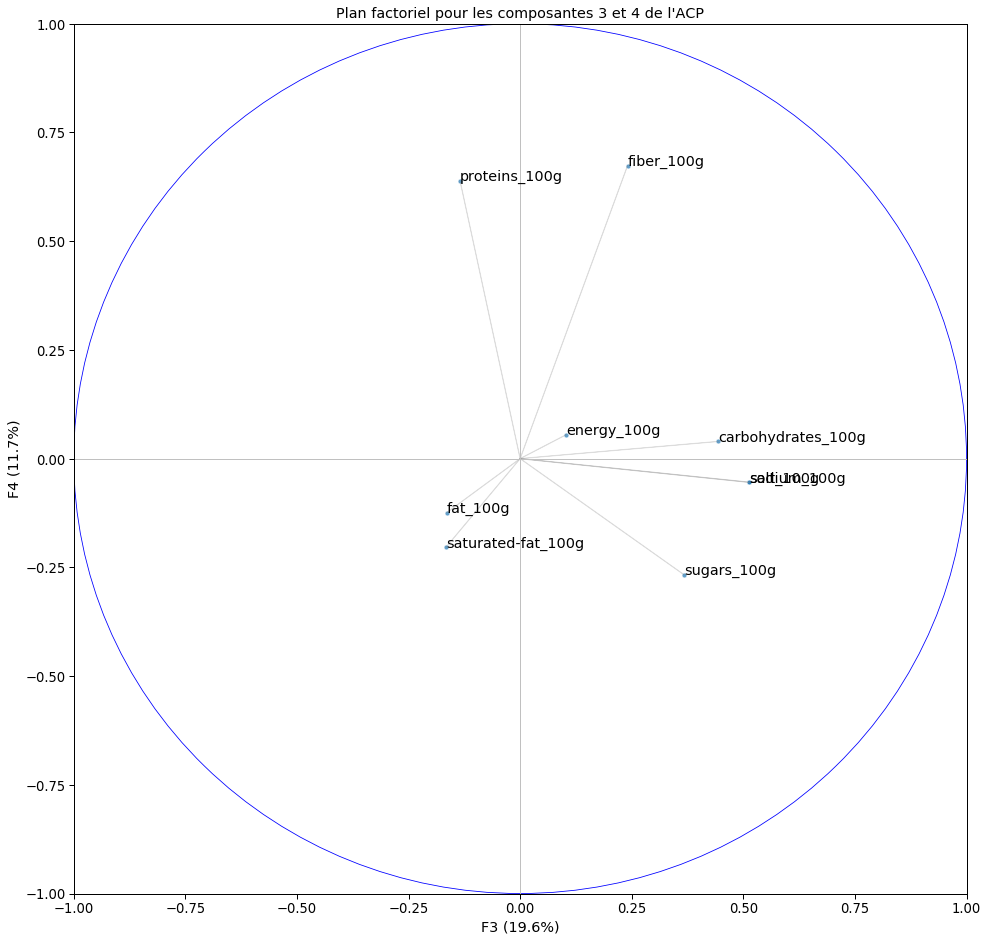

In [170]:
xpca =pca.components_[2,:]
ypca =pca.components_[3,:]

print(pca.components_[2,:],'\n',pca.components_[3,:])
fig, axes = plt.subplots(figsize=(16,16))

plt.title("Plan factoriel pour les composantes 3 et 4 de l'ACP")
plt.xlabel('F3 ({}%)'.format(np.around(var_ratio[2]*100,1)))
plt.ylabel('F4 ({}%)'.format(np.around(var_ratio[3]*100,1)))

axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

sns.scatterplot(x= xpca, y= ypca ,alpha = 0.7)

for i in range(len(cols)):
    plt.annotate(cols[i], (xpca[i],ypca[i]))
    axes.arrow(0, 0, xpca[i], ypca[i], head_width=0, head_length=0, fc='grey', ec='grey',alpha=0.2)

Que ce soit pour les composantes 1, 2, 3 ou 4 (en tout 85% de l'inertie totale des composantes), on observe des corrélations fortes entre certaines features :

- Sodium & salt (+++)
- Fat & Saturated Fat (++) 
- Carbohydrates & sugars (+)

In [149]:
cols


['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

# Prediction

## Create Cleaning Function 

In [232]:
def data_cleaning(data):

    print('======================\nDébut de la phase de cleaning\n======================')
    
    print('Gestion des valeurs inférieures à 0g et supérieures à 100g:')
    nan = 0
    
    for i in range(data.shape[0]):
        for j in range(2,len(data.columns)):
            if not np.isnan(data.iat[i,j]):
                if ((data.iat[i,j]<0)|(data.iat[i,j]>100)):
                    data.iat[i,j] = np.nan
                    nan +=1
    print(nan,' valeurs aberrantes mises à NaN\n___________________________')
    
    print('Gestion des outliers pour la variable: energy_100g:')
    nan = data['energy_100g'].count()
    data['energy_100g']= data['energy_100g'].where(data['energy_100g']<3761)
    
    nan -= data['energy_100g'].count()
    print(nan,' valeurs aberrantes mises à NaN\n___________________________')
    
    print('Remplissage des NaNs via KNN Imputer (fitté sur le train)')
    

    scaler_1 =StandardScaler()
    train_scaled = scaler_1.fit_transform(train.drop(columns=['nutriscore_score']))
    scaled_data= scaler_1.transform(data.drop(columns=['nutriscore_score']))
    
    knn_imputer=KNNImputer(n_neighbors = 6)
    knn_imputer.fit(train_scaled)
    knn_data= knn_imputer.transform(scaled_data)
    
    filled_data = scaler_1.inverse_transform(knn_data)
    
    data_return = pd.DataFrame(filled_data, columns=data.columns[1:], index=data.index)
    data_return.insert(0,'nutriscore_score',data['nutriscore_score'].values)
    print('Les Nans du dataframe ont été imputés via KNNImputer\n___________________________')
    
    print('Suppression des lignes avec une somme des macronutriments supérieure à 100g:')
    suppr= data_return.shape[0]
    data_return['sum_100g']=(data_return['fat_100g']+data_return['carbohydrates_100g']+data_return['fiber_100g']
                             +data_return['proteins_100g']+data_return['salt_100g'])
    data_return= data_return.loc[data_return['sum_100g']<=100]
    data_return= data_return.drop(columns='sum_100g')
    suppr-=data_return.shape[0]
    print(suppr,' lignes supprimées\n___________________________')
    
    print('Suppression outliers multivariés avec KDTree:')
    suppr= data_return.shape[0]
    
    scaler_2 = StandardScaler()
    train_scaled2 = scaler_2.fit_transform(train)
    scaled_data = scaler_2.transform(data_return)
    
    scaled_tree = spatial.KDTree(train_scaled2)
    neighbours_scaled = scaled_tree.query(scaled_data,k=6)
    dist_scaled = pd.DataFrame(neighbours_scaled[0])
    dist_scaled = dist_scaled.drop(columns=0)
    dist_scaled['mean']=dist_scaled.mean(axis=1)
    data_return['mean']=dist_scaled['mean'].values
    data_return= data_return.loc[data_return['mean']<0.84]
    suppr-= data_return.shape[0]
    print(suppr,' lignes supprimées\n___________________________')
    data_return = data_return.drop(columns=['mean'])
    
    
    return data_return
    

## Clean Test Dataframe

In [209]:
print(test.shape,'\n',test.describe(),'\n')
test.head()

(170199, 10) 
        nutriscore_score   energy_100g       fat_100g  saturated-fat_100g  \
count     170199.000000  1.697540e+05  169740.000000       169740.000000   
mean           9.241053  1.190077e+03      14.347305            5.313589   
std            8.925351  7.050885e+03      17.635264            8.006703   
min          -15.000000  0.000000e+00       0.000000            0.000000   
25%            1.000000  4.560000e+02       1.100000            0.100000   
50%           10.000000  1.125000e+03       8.000000            2.000000   
75%           16.000000  1.703000e+03      22.860000            7.600000   
max           40.000000  2.887646e+06    1000.000000          600.000000   

       carbohydrates_100g    sugars_100g     fiber_100g  proteins_100g  \
count       169653.000000  169741.000000  106570.000000  169744.000000   
mean            29.046180      13.438379       2.839900       8.334602   
std             27.580367      18.673669       4.616946       8.701104   
min 

,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,5.0,925.0,17.00,4.30,0.60,0.60,NaN,16.00,1.0000,0.400
1,12.0,2188.0,31.90,2.60,51.00,0.70,NaN,5.00,0.9700,0.388
2,9.0,2243.0,32.14,1.79,57.14,3.57,3.6,7.14,1.2050,0.482
3,-3.0,385.0,0.00,0.00,16.15,0.00,4.6,6.15,0.8275,0.331
4,-1.0,649.0,5.40,0.90,0.70,0.00,NaN,26.00,0.7000,0.280


In [216]:
test3=data_cleaning(test)
print(test3.shape,'\n',test3.describe(),'\n')
test3.head()

Début de la phase de cleaning
Gestion des valeurs inférieures à 0g et supérieures à 100g:
138  valeurs aberrantes mises à NaN
___________________________
Gestion des outliers pour la variable: energy_100g:
850  valeurs aberrantes mises à NaN
___________________________
Remplissage des NaNs via KNN Imputer (fitté sur le train)
Les Nans du dataframe ont été imputés via KNNImputer
___________________________
Suppression des lignes avec une somme des macronutriments supérieure à 100g:
11106  lignes supprimées
___________________________
Suppression outliers multivariés avec KDTree:
2351  lignes supprimées
___________________________


AttributeError: 'tuple' object has no attribute 'shape'

In [220]:
test3

,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,5.0,925.0,17.00,4.3,0.60,0.60,0.463333,16.00,1.0000,0.4000
1,12.0,2188.0,31.90,2.6,51.00,0.70,3.853333,5.00,0.9700,0.3880
3,-3.0,385.0,0.00,0.0,16.15,0.00,4.600000,6.15,0.8275,0.3310
4,-1.0,649.0,5.40,0.9,0.70,0.00,0.000000,26.00,0.7000,0.2800
5,0.0,0.0,0.00,0.0,0.00,0.00,0.000000,0.00,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...
170194,-6.0,444.0,0.59,0.0,22.35,9.41,2.400000,3.53,0.2200,0.0880
170195,26.0,2469.0,41.20,22.4,46.80,45.00,1.080000,6.80,0.1700,0.0680
170196,18.0,948.0,10.50,1.5,29.00,22.70,0.700000,3.40,4.9000,1.9600
170197,2.0,540.0,7.50,1.9,10.90,1.10,1.800000,3.60,0.8100,0.3240


In [221]:
test3.to_csv (r'C:\Users\quent\Desktop\Formation_OCR\Projets\Projet_3\test_3.csv', index = False, header=True)

## Linear regressor

In [231]:
# train.drop(columns=['binned'],inplace=True)
# train

Score de la prédiction (R²) sur train:  0.6206815904230714
Score de la prédiction (R²):  0.6260759036913889


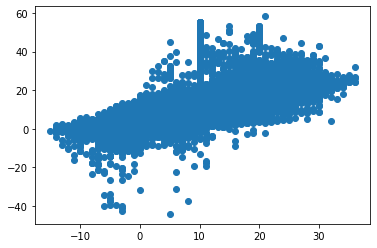

In [40]:
scaler = StandardScaler()

X= train.drop(columns=['nutriscore_score'])
X = scaler.fit_transform(X)

y= train['nutriscore_score'].values
y = y.reshape(train.shape[0], 1)

Xtest= test2.drop(columns=['nutriscore_score'])
Xtest = scaler.transform(Xtest)
ytest= test2['nutriscore_score'].values
ytest = ytest.reshape(test2.shape[0], 1)


linear_model = LinearRegression()
linear_model.fit(X,y)


print('Score de la prédiction (R²) sur train: ',linear_model.score(X,y))
print('Score de la prédiction (R²): ',linear_model.score(Xtest,ytest))

predict = linear_model.predict(Xtest)
plt.scatter(ytest,predict)
# plt.plot(X,predict,c='r', lw=3)


In [44]:
predict=pd.DataFrame(data=predict)
predict['nutriscore']=test2['nutriscore_score']
predict.describe()

,0,nutriscore
count,159037.000000,148610.000000
mean,9.220771,9.030186
std,7.111163,8.893977
min,-44.044231,-15.000000
25%,3.660006,1.000000
50%,7.293254,10.000000
75%,13.987662,16.000000
max,58.235002,36.000000


In [41]:
print('Poids de chaque variable dans la régression:')
linear_coefs = pd.DataFrame(columns=['Feature','Coef'])
linear_coefs['Feature']=test2.columns[1:]
linear_coefs['Coef']=linear_model.coef_[0]
linear_coefs


Poids de chaque variable dans la régression:


,Feature,Coef
0,energy_100g,3.099802
1,fat_100g,0.010714
2,saturated-fat_100g,2.877117
3,carbohydrates_100g,-0.724187
4,sugars_100g,3.840426
5,fiber_100g,-1.707929
6,proteins_100g,0.554542
7,salt_100g,2.751464
8,sodium_100g,-1.190483


## KNN Regressor

### Test cross validation

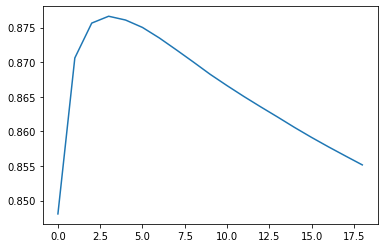

In [46]:

xtrain = train.drop(columns=['nutriscore_score'])
ytrain = train['nutriscore_score']

val_score = []
for i in range(1,20):
    score = cross_val_score(KNeighborsRegressor(i),xtrain,ytrain,cv=5).mean()
    val_score.append(score)
plt.plot(val_score)

First overview of crossvalidation function for KNN Regressor (1 Neighbor to 20) 

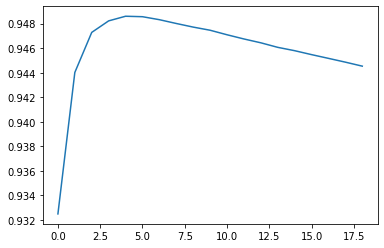

In [47]:
scaler = StandardScaler()

xtrain = scaler.fit_transform(train.drop(columns=['nutriscore_score']))
ytrain = train['nutriscore_score']

val_score = []
for i in range(1,20):
    score = cross_val_score(KNeighborsRegressor(i),xtrain,ytrain,cv=5).mean()
    val_score.append(score)
plt.plot(val_score)

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass param_name=n_neighbors, param_range=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


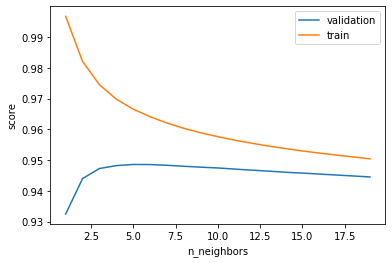

In [48]:
model = KNeighborsRegressor()
k = np.arange(1,20)

train_score2, val_score = validation_curve(model,xtrain,ytrain,'n_neighbors',k,cv=5)

plt.plot(k, val_score.mean(axis=1),label='validation')
plt.plot(k, train_score2.mean(axis=1),label='train')

plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()




In [50]:
nbneigh = val_score.mean(axis=1)
best=np.where(nbneigh== nbneigh.max())

print("Best Neighbors number: ", best[0][0]+1, "\nBest neighbors accuracy result : ", nbneigh.max()*100,"%")

Best Neighbors number:  5 
Best neighbors accuracy result :  94.85970162173957 %


### GridSearchCV with KNNRegressor

KNN Regressor optimized with GridSearchCV for all features 

In [53]:
scaler = StandardScaler()

xtrain = scaler.fit_transform(train.drop(columns=['nutriscore_score']))
ytrain = train['nutriscore_score']

param_grid = {'n_neighbors':np.arange(1,20)}
scoring = ['r2','neg_mean_absolute_error','neg_mean_squared_error']

for i in range(len(scoring)):
    
    grid= GridSearchCV(KNeighborsRegressor(),param_grid,cv=5,scoring=scoring[i])
    grid.fit(xtrain,ytrain)
    
    print('Methode de Scoring: ',scoring[i])
    print('Meilleur score :',grid.best_score_)
    print('Meilleurs Paramètres :',grid.best_params_,'\n__________________')
    
    if i == 0 : 
        model_1 = grid.best_estimator_
    elif i == 1 : 
        model_2 = grid.best_estimator_
    else:
        model_3 = grid.best_estimator_



Methode de Scoring:  r2
Meilleur score : 0.9485970162173958
Meilleurs Paramètres : {'n_neighbors': 5} 
__________________
Methode de Scoring:  neg_mean_absolute_error
Meilleur score : -0.921002810035702
Meilleurs Paramètres : {'n_neighbors': 1} 
__________________
Methode de Scoring:  neg_mean_squared_error
Meilleur score : -4.062249569922076
Meilleurs Paramètres : {'n_neighbors': 5} 
__________________


### Prediction with dropping some features

As we found out some correlated feature, it would be interresting to try removing some of theim to see if they have a bad influence on the weights of our KNN Model

Let's study the results with removing 'saturated-fat','sugars' and 'sodium'

In [5]:
train_cleaned = train.drop(columns=['saturated-fat_100g','sugars_100g','sodium_100g'])
test_cleaned = test_2.drop(columns=['saturated-fat_100g','sugars_100g','sodium_100g'])

list_matrix = ['saturated-fat_100g','sugars_100g','sodium_100g',['saturated-fat_100g','sugars_100g'],
               ['saturated-fat_100g','sodium_100g'],['sugars_100g','sodium_100g'],
               ['saturated-fat_100g','sugars_100g','sodium_100g']]
d = {'col': list_matrix}
index_matrix = ['sans saturated fat','sans sugars','sans sodium','sans saturated fat & sugars',
               'sans saturated fat & sodium','sans sugars et sodium','sans saturates fat & sugars & sodium']
matrix_features= pd.DataFrame(data=d)
matrix_features.index = index_matrix
matrix_features




,col
sans saturated fat,saturated-fat_100g
sans sugars,sugars_100g
sans sodium,sodium_100g
sans saturated fat & sugars,"[saturated-fat_100g, sugars_100g]"
sans saturated fat & sodium,"[saturated-fat_100g, sodium_100g]"
sans sugars et sodium,"[sugars_100g, sodium_100g]"
sans saturates fat & sugars & sodium,"[saturated-fat_100g, sugars_100g, sodium_100g]"


In [9]:
scaler = StandardScaler()

xtrain = scaler.fit_transform(train_cleaned.drop(columns=['nutriscore_score']))
ytrain = train_cleaned['nutriscore_score']

param_grid = {'n_neighbors':np.arange(1,20)}
scoring = ['r2','neg_mean_absolute_error','neg_mean_squared_error']

for i in range(len(scoring)):
    
    grid= GridSearchCV(KNeighborsRegressor(),param_grid,cv=5,scoring=scoring[i])
    grid.fit(xtrain,ytrain)
    
    print('Methode de Scoring: ',scoring[i])
    print('Meilleur score :',grid.best_score_)
    print('Meilleurs Paramètres :',grid.best_params_,'\n__________________')
    
    if i == 0 : 
        model_1 = grid.best_estimator_
        result_1 = pd.DataFrame(grid.cv_results_)
    elif i == 1 : 
        model_2 = grid.best_estimator_
        result_2 = pd.DataFrame(grid.cv_results_)
    else:
        model_3 = grid.best_estimator_
        result_3 = pd.DataFrame(grid.cv_results_)


Methode de Scoring:  r2
Meilleur score : 0.897350179771632
Meilleurs Paramètres : {'n_neighbors': 6} 
__________________
Methode de Scoring:  neg_mean_absolute_error
Meilleur score : -1.5196466490227403
Meilleurs Paramètres : {'n_neighbors': 1} 
__________________
Methode de Scoring:  neg_mean_squared_error
Meilleur score : -8.112165009877485
Meilleurs Paramètres : {'n_neighbors': 6} 
__________________


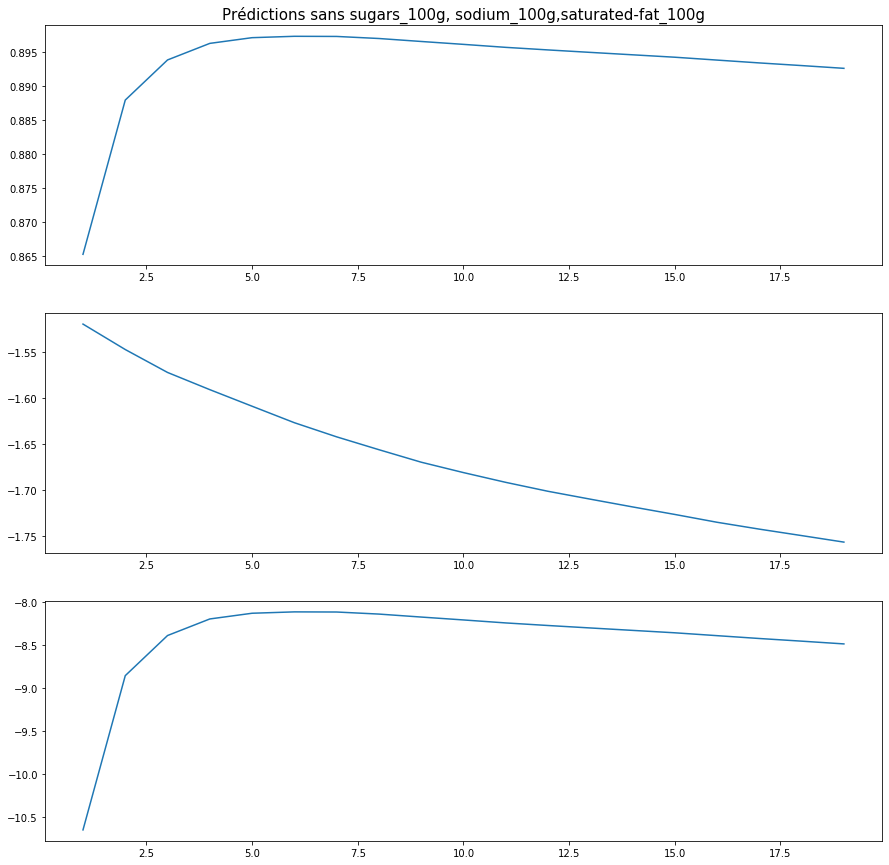

In [24]:
fig, axs = plt.subplots(3,figsize=(15,15))

axs[0].plot(result_1['param_n_neighbors'],result_1['mean_test_score'])
axs[0].set_title('Prédictions sans sugars_100g, sodium_100g,saturated-fat_100g',fontsize=15)
axs[1].plot(result_2['param_n_neighbors'],result_2['mean_test_score'])
axs[2].plot(result_3['param_n_neighbors'],result_3['mean_test_score'])

In [7]:
matrix_features= matrix_features.reindex(columns=['col','r2','neg_mean_absolute_error','neg_mean_squared_error'])

matrix_features.iloc[0,1]='test' 
matrix_features

,col,r2,neg_mean_absolute_error,neg_mean_squared_error
sans saturated fat,saturated-fat_100g,test,NaN,NaN
sans sugars,sugars_100g,NaN,NaN,NaN
sans sodium,sodium_100g,NaN,NaN,NaN
sans saturated fat & sugars,"[saturated-fat_100g, sugars_100g]",NaN,NaN,NaN
sans saturated fat & sodium,"[saturated-fat_100g, sodium_100g]",NaN,NaN,NaN
sans sugars et sodium,"[sugars_100g, sodium_100g]",NaN,NaN,NaN
sans saturates fat & sugars & sodium,"[saturated-fat_100g, sugars_100g, sodium_100g]",NaN,NaN,NaN


Prediction: sans saturated fat
Prediction: sans sugars
Prediction: sans sodium
Prediction: sans saturated fat & sugars
Prediction: sans saturated fat & sodium
Prediction: sans sugars et sodium
Prediction: sans saturates fat & sugars & sodium


,col,r2,neg_mean_absolute_error,neg_mean_squared_error
sans saturated fat,saturated-fat_100g,0.923408,-1.259147,-6.052823
sans sugars,sugars_100g,0.932598,-1.124096,-5.326558
sans sodium,sodium_100g,0.946746,-0.957152,-4.208524
sans saturated fat & sugars,"[saturated-fat_100g, sugars_100g]",0.897964,-1.509248,-8.063685
sans saturated fat & sodium,"[saturated-fat_100g, sodium_100g]",0.9221,-1.277486,-6.156246
sans sugars et sodium,"[sugars_100g, sodium_100g]",0.931532,-1.144292,-5.410799
sans saturates fat & sugars & sodium,"[saturated-fat_100g, sugars_100g, sodium_100g]",0.89735,-1.519647,-8.112165


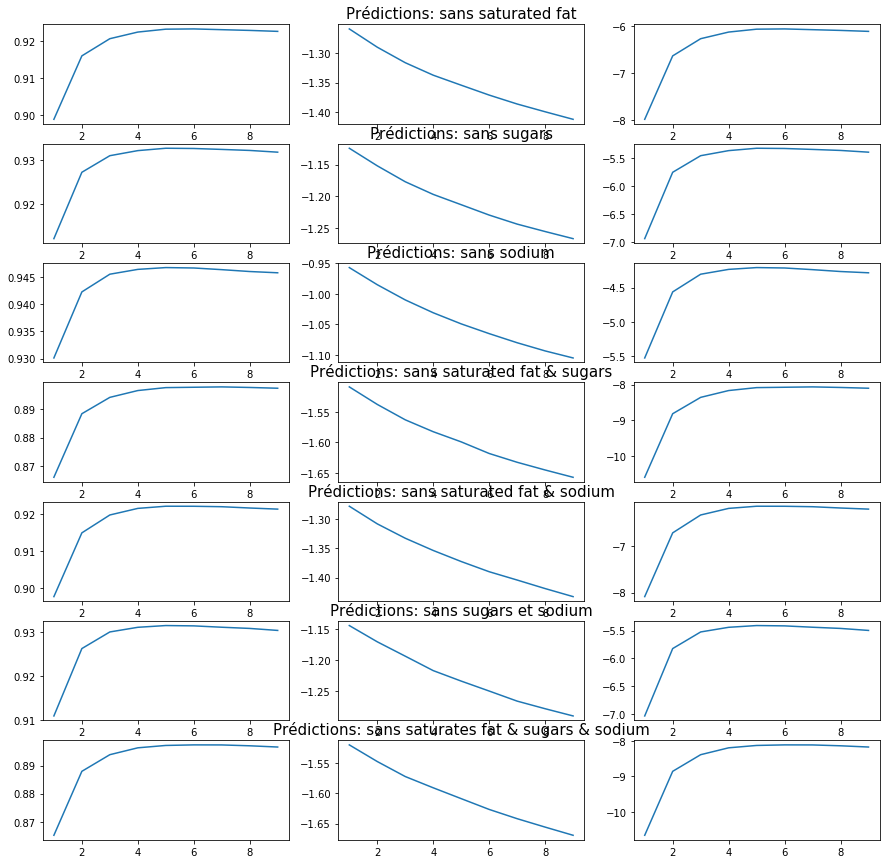

In [8]:
fig, axs = plt.subplots(matrix_features.shape[0],3,figsize=(15,15))
axs = axs.ravel()
counter = 0 

for k in range(matrix_features.shape[0]):
    scaler = StandardScaler()
    print('Prediction: {}'.format(matrix_features.index[k]))
    train_used = train.drop(columns=matrix_features.col[k])
    xtrain = scaler.fit_transform(train_used.drop(columns=['nutriscore_score']))
    ytrain = train_used['nutriscore_score']

    param_grid = {'n_neighbors':np.arange(1,10)}
    scoring = ['r2','neg_mean_absolute_error','neg_mean_squared_error']

    for i in range(len(scoring)):

        grid= GridSearchCV(KNeighborsRegressor(),param_grid,cv=5,scoring=scoring[i])
        grid.fit(xtrain,ytrain)

#         print('Methode de Scoring: ',scoring[i])
#         print('Meilleur score :',grid.best_score_)
#         print('Meilleurs Paramètres :',grid.best_params_,'\n__________________')
        matrix_features.iloc[k,i+1]=grid.best_score_

        if i == 0 : 
            model_1 = grid.best_estimator_
            result_1 = pd.DataFrame(grid.cv_results_)
            axs[counter].plot(result_1['param_n_neighbors'],result_1['mean_test_score'])
            counter+=1
        elif i == 1 : 
            model_2 = grid.best_estimator_
            result_2 = pd.DataFrame(grid.cv_results_)
            axs[counter].set_title('Prédictions: {}'.format(matrix_features.index[k]),fontsize=15)
            axs[counter].plot(result_2['param_n_neighbors'],result_2['mean_test_score'])
            counter+=1
        else:
            model_3 = grid.best_estimator_
            result_3 = pd.DataFrame(grid.cv_results_)
            axs[counter].plot(result_3['param_n_neighbors'],result_3['mean_test_score'])    
            counter+=1

#     fig, axs = plt.subplots(3,figsize=(15,15))

matrix_features          

### Prediction sur le test

After training our model on the Train dataset, let's observ the result we obtain on an unknown dataset (test dataset)

In [224]:
scaler = StandardScaler()

xtrain = scaler.fit_transform(train.drop(columns=['nutriscore_score']))
ytrain = train['nutriscore_score']

param_grid = {'n_neighbors':np.arange(1,10)}



    
grid= GridSearchCV(KNeighborsRegressor(),param_grid,cv=5,scoring='r2')
grid.fit(xtrain,ytrain)
    
print('Meilleur score :',grid.best_score_)
print('Meilleurs Paramètres :',grid.best_params_,'\n__________________')
  
    
model_1 = grid.best_estimator_


Meilleur score : 0.9485970162173958
Meilleurs Paramètres : {'n_neighbors': 5} 
__________________


In [1]:
xtest = scaler.transform(test3.drop(columns=['nutriscore_score']))
ytest = test3['nutriscore_score']

print('Score estimé sur les données de test: ', np.around(model_1.score(xtest,ytest),2),'%')


Score estimé sur les données de test: 0.93


In [64]:
test_predict=model_1.predict(xtest)
test_predict=pd.DataFrame(data=test_predict,columns=['Predict'])
test_predict['nutriscore']=test3['nutriscore_score'].values
test_predict.describe()

,Predict,nutriscore
count,159037.000000,159037.000000
mean,8.920656,9.024768
std,8.718580,8.897745
min,-14.000000,-15.000000
25%,1.600000,1.000000
50%,9.000000,10.000000
75%,15.600000,16.000000
max,34.400000,36.000000


### Etude influence des NaNs 

Study of the NaN's influence on the prediction accuracy 

In [200]:
test_nan_bis = test.iloc[170194:170196]
test_nan_bis=test_nan_bis.drop(index=170195)
test_nan_bis = pd.DataFrame(np.repeat(test_nan_bis.values,8,axis=0))
test_nan_bis.columns = test.columns
for i in range(test_nan_bis.shape[0]):
    if i!=0:
        nans = random.sample(range(1,10),i)
        for k in range(i):
            test_nan_bis.iloc[i,nans[k]]=np.nan
test_nan_bis

,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,-6.0,444.0,0.59,0.0,22.35,9.41,2.4,3.53,0.22,0.088
1,-6.0,444.0,0.59,0.0,22.35,NaN,2.4,3.53,0.22,0.088
2,-6.0,444.0,0.59,NaN,NaN,9.41,2.4,3.53,0.22,0.088
3,-6.0,444.0,0.59,0.0,NaN,NaN,2.4,3.53,NaN,0.088
4,-6.0,NaN,0.59,0.0,NaN,9.41,2.4,NaN,NaN,0.088
5,-6.0,NaN,NaN,NaN,22.35,NaN,2.4,3.53,NaN,0.088
6,-6.0,NaN,NaN,NaN,22.35,9.41,2.4,NaN,NaN,NaN
7,-6.0,NaN,NaN,NaN,NaN,9.41,NaN,NaN,NaN,0.088


In [201]:

cleaned_testnan = data_cleaning_bis(test_nan_bis)
cleaned_testnan

Début de la phase de cleaning
Gestion des valeurs inférieures à 0g et supérieures à 100g:
0  valeurs aberrantes mises à NaN
___________________________
Gestion des outliers pour la variable: energy_100g:
0  valeurs aberrantes mises à NaN
___________________________
Remplissage des NaNs via KNN Imputer (fitté sur le train)
Les Nans du dataframe ont été imputés via KNNImputer
___________________________
Suppression des lignes avec une somme des macronutriments supérieure à 100g:
0  lignes supprimées
___________________________
Suppression outliers multivariés avec KDTree:
1  lignes supprimées
___________________________


,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,-6.0,444.000000,0.590000,0.000000e+00,22.350000,9.41,2.400,3.530000,0.220000,0.088
1,-6.0,444.000000,0.590000,0.000000e+00,22.350000,8.43,2.400,3.530000,0.220000,0.088
2,-6.0,444.000000,0.590000,-8.881784e-16,22.350000,9.41,2.400,3.530000,0.220000,0.088
3,-6.0,444.000000,0.590000,0.000000e+00,22.350000,8.43,2.400,3.530000,0.000000,0.088
4,-6.0,185.800000,0.590000,0.000000e+00,12.626667,9.41,2.400,1.546667,0.483483,0.088
6,-6.0,444.000000,0.590000,-8.881784e-16,22.350000,9.41,2.400,3.530000,0.000000,0.000
7,-6.0,638.666667,7.951667,4.581667e+00,17.390000,9.41,0.926,5.280000,0.217333,0.088


In [202]:
x_test= scaler.transform(cleaned_testnan.drop(columns=['nutriscore_score']))
cleaned_testnan['predict']=model.predict(x_test)

In [203]:
cleaned_testnan

,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,predict
0,-6.0,444.000000,0.590000,0.000000e+00,22.350000,9.41,2.400,3.530000,0.220000,0.088,-6.0
1,-6.0,444.000000,0.590000,0.000000e+00,22.350000,8.43,2.400,3.530000,0.220000,0.088,-6.0
2,-6.0,444.000000,0.590000,-8.881784e-16,22.350000,9.41,2.400,3.530000,0.220000,0.088,-6.0
3,-6.0,444.000000,0.590000,0.000000e+00,22.350000,8.43,2.400,3.530000,0.000000,0.088,-6.0
4,-6.0,185.800000,0.590000,0.000000e+00,12.626667,9.41,2.400,1.546667,0.483483,0.088,-3.8
6,-6.0,444.000000,0.590000,-8.881784e-16,22.350000,9.41,2.400,3.530000,0.000000,0.000,-6.0
7,-6.0,638.666667,7.951667,4.581667e+00,17.390000,9.41,0.926,5.280000,0.217333,0.088,3.8


# Graphiques manquants pour notation 

In [6]:
train.head()

,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,binned
0,13.0,1071.0,1.776357e-15,0.00,61.54,58.97,0.00,0.00,0.00,0.000,c
1,19.0,1393.0,2.667000e+01,16.67,3.33,0.00,0.00,23.33,2.50,1.000,d
2,21.0,1690.0,1.260000e+01,6.60,67.10,46.90,1.88,3.30,0.13,0.052,d
3,8.0,431.0,7.800000e+00,3.90,4.20,1.20,0.78,4.10,1.40,0.560,c
4,-4.0,247.0,2.800000e+00,1.90,1.80,0.70,1.40,2.70,0.67,0.268,b


In [34]:
pie_nutri = pd.DataFrame(columns=['count'])
for i in range(5):
    pie_nutri.loc[train.binned.unique()[i]]=train.binned.value_counts()[train.binned.unique()[i]]
pie_nutri

,count
c,136297
d,58029
b,151923
a,16372
e,316


Text(0.5, 1.0, 'Distribution of Nutrition Grades (percentage) ')

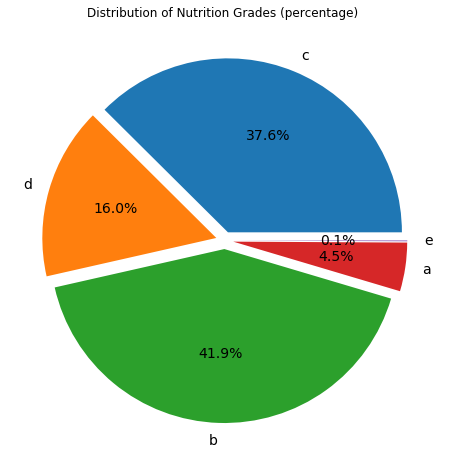

In [35]:
explode = (0.05,0.05,0.05,0.05,0.05)    

plt.figure(figsize=(12,8))
plt.pie(pie_nutri['count'],labels=pie_nutri.index,explode=explode,autopct='%1.1f%%',textprops={'fontsize': 14})
plt.title('Distribution of Nutrition Grades (percentage) ')

Text(0.5, 1.0, 'Nutriscore base upon energy_100g')

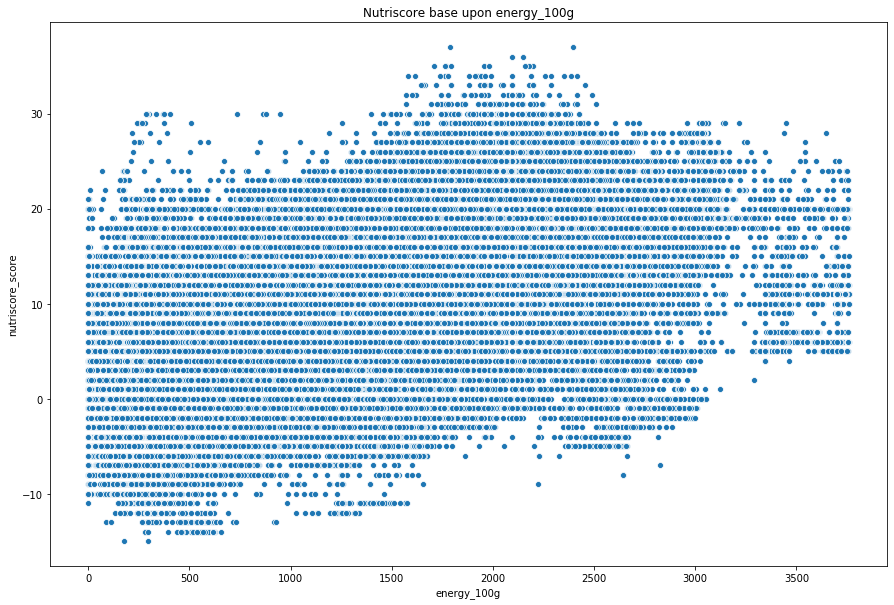

In [41]:
plt.figure(figsize=(15,10))
sns.scatterplot(train['energy_100g'],train['nutriscore_score'])
plt.title('Nutriscore base upon energy_100g')

Text(0.5, 1.0, 'Regression : Nutriscore base upon energy_100g')

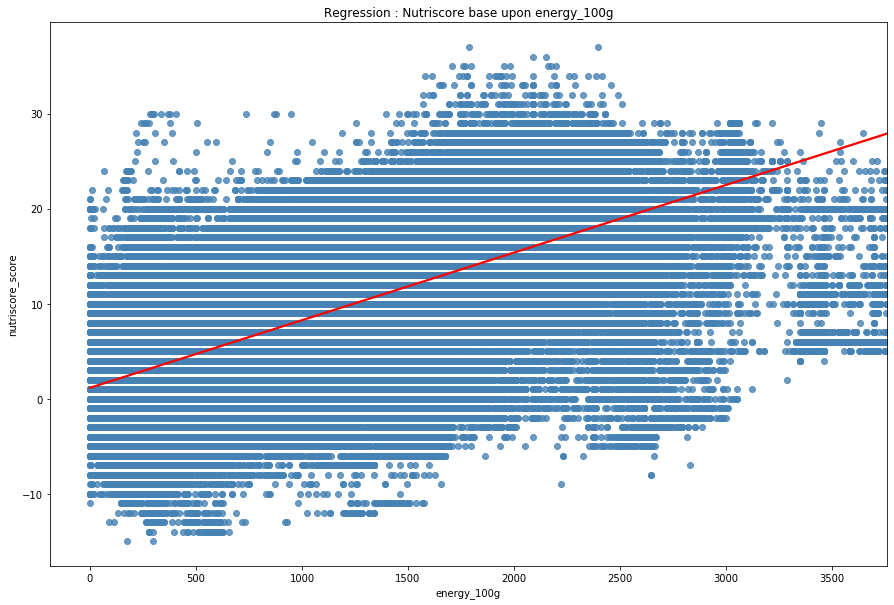

In [43]:
plt.figure(figsize=(15,10))

sns.regplot(x="energy_100g", y="nutriscore_score", data=train,scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
plt.title('Regression : Nutriscore base upon energy_100g')